# Age recognition 

**Authors**: Richard Šléher, Tomáš Majerník

**Dataset**: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/code?select=train.csv

# TODO
- wandb
- hyperparameter tuning (sweep)

In [58]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from summarytools import dfSummary
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")


Hyperparameters

In [4]:
IMAGE_SIZE = 128

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


## EDA

In [46]:
data = pd.read_csv('data/train.csv')

In [34]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 377.jpg2. 13367.jpg3. 18458.jpg4. 1062.jpg5. 9391.jpg6. 23526.jpg7. 18911.jpg8. 18595.jpg9. 14060.jpg10. 538.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)19,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/GU6VOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"10,804 (54.3%)6,706 (33.7%)2,396 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/GU6VOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


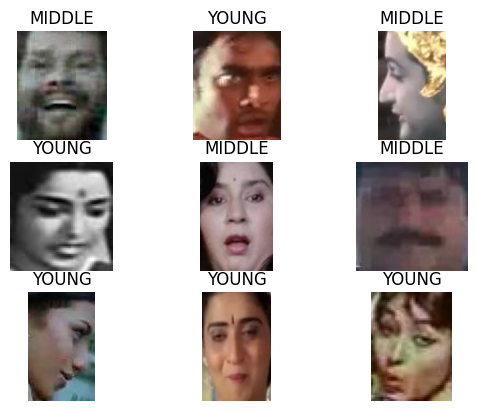

In [7]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread('data/train/' + data.iloc[i]['ID'])
    plt.imshow(img)
    plt.title(data.iloc[i]['Class'])
    plt.axis('off')

plt.show()

In [39]:
sampled_data = data.groupby('Class').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)

remaining_data = data.drop(sampled_data.index)
print(f"Training data size: {sampled_data.shape}")
print(f"Validation data size: {remaining_data.shape}")

Training data size: (6000, 2)
Validation data size: (13906, 2)


C:\Users\admin\AppData\Local\Temp\ipykernel_21596\3918876274.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('Class').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)


In [ ]:
X = data['ID']  
y = data['Class']  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [48]:
print("X_train (filenames):")
print(X_train.head())  # Print the first few filenames in the training set
print("y_train (labels):")
print(y_train.head())  # Print the corresponding labels for the training set

print("\nX_val (filenames):")
print(X_val.head())  # Print the first few filenames in the validation set
print("y_val (labels):")
print(y_val.head())  # Print the corresponding labels for the validation set

print("\nX_test (filenames):")
print(X_test.head())  # Print the first few filenames in the test set
print("y_test (labels):")
print(y_test.head())  # Print the corresponding labels for the test set

X_train (filenames):
2133     25558.jpg
9914     19322.jpg
17831     4623.jpg
6233     18640.jpg
1275      8841.jpg
Name: ID, dtype: object
y_train (labels):
2133     MIDDLE
9914     MIDDLE
17831    MIDDLE
6233     MIDDLE
1275        OLD
Name: Class, dtype: object

X_val (filenames):
19114    18539.jpg
10146    16808.jpg
16214     7101.jpg
7526      1417.jpg
17471    26327.jpg
Name: ID, dtype: object
y_val (labels):
19114     YOUNG
10146    MIDDLE
16214     YOUNG
7526      YOUNG
17471    MIDDLE
Name: Class, dtype: object

X_test (filenames):
18423     7016.jpg
7377      4305.jpg
11883     8855.jpg
2408     18669.jpg
13420    18561.jpg
Name: ID, dtype: object
y_test (labels):
18423    MIDDLE
7377      YOUNG
11883     YOUNG
2408     MIDDLE
13420     YOUNG
Name: Class, dtype: object


In [9]:
dfSummary(sampled_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 14828.jpg2. 19906.jpg3. 20663.jpg4. 24434.jpg5. 21379.jpg6. 21781.jpg7. 2993.jpg8. 1928.jpg9. 10061.jpg10. 10055.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)5,990 (99.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/GU6VOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. OLD3. YOUNG,"2,000 (33.3%)2,000 (33.3%)2,000 (33.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/GU6VOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABZUlEQVR4nO3bQWrCYBSF0ZcSSp0kBMHFuIgutovIbkT8B23pJB10aGeV+4s9ZwVP+FAiucO2bQUJT70P4P8YqmpXVc+9D7mhr23bPnofwbVxv9+/TtO09D7kVlpr52EY3gR3f8Zpmpbj8fgxz/Nn72P+6nK5vKzrupxOp+eqEtudGauq5nn+PBwO772PuZFd7wP4nQcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSMVT/vgfU+5BYe5XM8qrG1dl7XdakHeQ+stXauqq/ed3DNBoGYwZSPFN9sxFhXEWNdRYx1FTH+1CVGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjHUVMdZVxNggEGNdRYwHBGL8jBJjykeMKR8xpnzEeEAgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERowpHzGmfMTYIBBjykfMN77xo0reSBZ8AAAAAElFTkSuQmCC"">",0(0.0%)


In [10]:
dfSummary(remaining_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 6989.jpg2. 10863.jpg3. 12403.jpg4. 64.jpg5. 288.jpg6. 6447.jpg7. 2914.jpg8. 25292.jpg9. 2692.jpg10. 24129.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)13,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/GU6VOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"7,551 (54.3%)4,659 (33.5%)1,696 (12.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/GU6VOAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [103]:
class AgeDataset(Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
        self.label_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2} 

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join('data/train/', self.filenames.iloc[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.labels.iloc[idx]
        label = self.label_mapping[label]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

# train_dataset = AgeDataset(dataframe=sampled_data, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=(128), shuffle=True)

# val_dataset = AgeDataset(dataframe=remaining_data, transform=transform)
# val_loader = DataLoader(val_dataset, batch_size=(128), shuffle=False)

# Use the splits for the dataset
train_dataset = AgeDataset(filenames=X_train, labels=y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = AgeDataset(filenames=X_val, labels=y_val, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# You can similarly create a test dataset if needed
test_dataset = AgeDataset(filenames=X_test, labels=y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


## Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 16 * 16)  
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

In [99]:
model = CNN(in_channels=3, num_classes=3)

In [96]:
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return val_loss / len(val_loader), accuracy, precision, recall, f1

In [104]:
class_weights = torch.tensor([1.0, 2.0, 3.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

# Training loop
model.to(device)

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100  

    val_loss, val_accuracy, precision, recall, f1 = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f},\
    Train Accuracy: {train_accuracy:.3f}%, Val Accuracy: {val_accuracy:.3f}%,\
    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}')

Epoch 1/100, Train Loss: 0.441, Val Loss: 0.521,    Train Accuracy: 79.934%, Val Accuracy: 0.772%,    Precision: 0.780, Recall: 0.772, F1: 0.768
Epoch 2/100, Train Loss: 0.422, Val Loss: 0.544,    Train Accuracy: 80.243%, Val Accuracy: 0.756%,    Precision: 0.772, Recall: 0.756, F1: 0.747
Epoch 3/100, Train Loss: 0.416, Val Loss: 0.556,    Train Accuracy: 80.415%, Val Accuracy: 0.782%,    Precision: 0.784, Recall: 0.782, F1: 0.778
Epoch 4/100, Train Loss: 0.419, Val Loss: 0.524,    Train Accuracy: 80.444%, Val Accuracy: 0.773%,    Precision: 0.783, Recall: 0.773, F1: 0.769
Epoch 5/100, Train Loss: 0.410, Val Loss: 0.543,    Train Accuracy: 80.666%, Val Accuracy: 0.792%,    Precision: 0.795, Recall: 0.792, F1: 0.788
Epoch 6/100, Train Loss: 0.407, Val Loss: 0.509,    Train Accuracy: 81.298%, Val Accuracy: 0.774%,    Precision: 0.786, Recall: 0.774, F1: 0.769
Epoch 7/100, Train Loss: 0.411, Val Loss: 0.538,    Train Accuracy: 80.522%, Val Accuracy: 0.762%,    Precision: 0.777, Recall: 0.

KeyboardInterrupt: 

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [ ]:
# torch.save(model.state_dict(), 'age_recognition_model.pth')